Have run riboprof_pt1.py and riboprof_pt2.py on the sequencing datasets. Have also parsed start distance, A sites, and read counts using scripts from /home/adelexu/research/riboprof/riboprof/scripts/.

This workflow is modeled on the one used in the S27(L)-FLAG IP riboprof one (see /home/adelexu/research/riboprof/riboprof/notebooks/S27L_read_count_analysis.ipynb and S27L_voom.ipynb), where I collate the read counts for all samples in Python in this notebook and analyze some global metrics like total 5' UTR read counts or CDS read counts, then perform the analysis using limma-voom and edgeR in another notebook. 

In [16]:
# this notebook requires the 'riboprof' conda environment

import glob
import os
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns

In [17]:
# read in each _readcounts.txt as a dataframe
# store in a dict of dataframes w/ IDs as keys

root_path = '/home/tsusanto/lab/ribosome_profiling/3_hiNd14-RNARFP_20230718/stage9/'

read_count_colnames = ['tx_id_v',
                       '5UTR',
                       'first15codons',
                       'CDS',
                       'last5codons',
                       '3UTR']

# import mart to label with gene names

mart = pd.read_csv('/labs/mbarna/index/mart_homo-sapiens_geneID_transcriptID_transcriptID-v_gene-name.txt', 
                   sep='\t', skiprows=1,
                   names=['gene_id', 'tx_id', 'tx_id_v', 'gene_name'])
name_for_tx = dict(zip(mart.tx_id, mart.gene_name))

# read in sample data

sample_dfs = {}

for source_path in glob.glob(os.path.join(root_path, '*', '*_readcounts.txt')):
    samp = os.path.basename(source_path).replace('_readcounts.txt', '')
    sample_dfs[samp] = pd.read_csv(source_path,
                                   sep='\t',
                                   header=None,
                                   names=read_count_colnames)
    sample_dfs[samp]['tx_id'] = [re.sub(r'\.\d*', '', tidv) for tidv in sample_dfs[samp]['tx_id_v']]
    sample_dfs[samp].set_index('tx_id', inplace=True)
    sample_dfs[samp].drop(columns='tx_id_v', inplace=True)
    sample_dfs[samp]['reads_per_tx'] = sample_dfs[samp].sum(axis=1)
    sample_dfs[samp]['rpm_per_tx'] = sample_dfs[samp]['reads_per_tx']/sample_dfs[samp]['reads_per_tx'].sum()*10**6

# CAUTION: _readcounts.txt rows cannot be compared directly by index -- different order of txs!!!

In [18]:
sample_dfs["hiND14_RFP_Nterm_rep2"]

,5UTR,first15codons,CDS,last5codons,3UTR,reads_per_tx,rpm_per_tx
tx_id,,,,,,,
ENST00000616016,64.0,10.0,739.0,1.0,9.0,823.0,62.703066
ENST00000327044,2.0,85.0,1979.0,12.0,27.0,2105.0,160.376615
ENST00000338591,2.0,8.0,139.0,0.0,1.0,150.0,11.428262
ENST00000379410,0.0,9.0,158.0,0.0,1.0,168.0,12.799654
ENST00000304952,42.0,78.0,268.0,7.0,1.0,396.0,30.170613
...,...,...,...,...,...,...,...
ENST00000361335,0.0,59.0,369.0,11.0,0.0,439.0,33.446714
ENST00000361381,0.0,15.0,1787.0,7.0,3.0,1812.0,138.053409
ENST00000361567,0.0,68.0,5158.0,6.0,0.0,5232.0,398.617790


In [19]:
# summarize the whole sample for each transcript region 
# -- how many total reads in each sample aligned to 5' UTRs, 1st 15 codons, etc.

samp_order = ['hiND14_RFP_wt_rep1',
              'hiND14_RFP_wt_rep2',
              'hiND14_RFP_wt_rep3',
              'hiND14_RFP_Nterm_rep1',
              'hiND14_RFP_Nterm_rep2',
              'hiND14_RFP_Nterm_rep3'
             ]

tot_reads_per_tx_region = {}

for samp in sample_dfs:
    tot_reads_per_tx_region[samp] = sample_dfs[samp].sum()
    
tot_reads_per_tx_region = pd.DataFrame(tot_reads_per_tx_region)[samp_order]
tot_reads_per_tx_region

,hiND14_RFP_wt_rep1,hiND14_RFP_wt_rep2,hiND14_RFP_wt_rep3,hiND14_RFP_Nterm_rep1,hiND14_RFP_Nterm_rep2,hiND14_RFP_Nterm_rep3
5UTR,819708.0,1199503.0,1076542.0,953615.0,945865.0,1184711.0
first15codons,559475.0,725536.0,640985.0,598976.0,568729.0,688201.0
CDS,11566812.0,14193750.0,12036112.0,10910202.0,11411558.0,13066047.0
last5codons,106286.0,124346.0,106980.0,97891.0,98359.0,115764.0
3UTR,102849.0,113284.0,110338.0,92149.0,100844.0,122587.0
reads_per_tx,13155130.0,16356419.0,13970957.0,12652833.0,13125355.0,15177310.0
rpm_per_tx,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


In [20]:
# convert these summary counts to percentages, re-format for plotting

pc_reads_per_tx_region = tot_reads_per_tx_region.drop(labels=['rpm_per_tx', 'reads_per_tx'], axis=0, inplace=False)
pc_reads_per_tx_region = pc_reads_per_tx_region/pc_reads_per_tx_region.sum(axis=0)
pc_reads_per_tx_region

,hiND14_RFP_wt_rep1,hiND14_RFP_wt_rep2,hiND14_RFP_wt_rep3,hiND14_RFP_Nterm_rep1,hiND14_RFP_Nterm_rep2,hiND14_RFP_Nterm_rep3
5UTR,0.062311,0.073335,0.077056,0.075368,0.072064,0.078058
first15codons,0.042529,0.044358,0.045880,0.047339,0.043331,0.045344
CDS,0.879262,0.867779,0.861509,0.862273,0.869429,0.860893
last5codons,0.008079,0.007602,0.007657,0.007737,0.007494,0.007627
3UTR,0.007818,0.006926,0.007898,0.007283,0.007683,0.008077


In [21]:
# re-shape for plotting
pc_reads_per_tx_region['tx_region'] = pc_reads_per_tx_region.index
pc_reads_per_tx_region = pd.melt(pc_reads_per_tx_region, id_vars='tx_region')

# assign a sample type (i.e. which genotype + RPF vs. RNA) to each sample
samp_name_to_type = {'hiND14_RFP_wt_rep1':'wt RFP',
                     'hiND14_RFP_wt_rep2':'wt RFP',
                     'hiND14_RFP_wt_rep3':'wt RFP',
                     'hiND14_RFP_Nterm_rep1':'Nterm RFP',
                     'hiND14_RFP_Nterm_rep2':'Nterm RFP',
                     'hiND14_RFP_Nterm_rep3':'Nterm RFP'
                    }

pc_reads_per_tx_region['samp_type'] = [samp_name_to_type[s] for s in pc_reads_per_tx_region['variable']]
pc_reads_per_tx_region['genotype'] = [s.split()[0] for s in pc_reads_per_tx_region.samp_type]
pc_reads_per_tx_region['RPF_or_RNA'] = [s.split()[1] for s in pc_reads_per_tx_region.samp_type]
pc_reads_per_tx_region['pc'] = [v*100 for v in pc_reads_per_tx_region['value']]
pc_reads_per_tx_region

,tx_region,variable,value,samp_type,genotype,RPF_or_RNA,pc
0,5UTR,hiND14_RFP_wt_rep1,0.062311,wt RFP,wt,RFP,6.231090
1,first15codons,hiND14_RFP_wt_rep1,0.042529,wt RFP,wt,RFP,4.252904
2,CDS,hiND14_RFP_wt_rep1,0.879262,wt RFP,wt,RFP,87.926246
3,last5codons,hiND14_RFP_wt_rep1,0.008079,wt RFP,wt,RFP,0.807943
4,3UTR,hiND14_RFP_wt_rep1,0.007818,wt RFP,wt,RFP,0.781817
5,5UTR,hiND14_RFP_wt_rep2,0.073335,wt RFP,wt,RFP,7.333531
6,first15codons,hiND14_RFP_wt_rep2,0.044358,wt RFP,wt,RFP,4.435788
7,CDS,hiND14_RFP_wt_rep2,0.867779,wt RFP,wt,RFP,86.777858
8,last5codons,hiND14_RFP_wt_rep2,0.007602,wt RFP,wt,RFP,0.760228
9,3UTR,hiND14_RFP_wt_rep2,0.006926,wt RFP,wt,RFP,0.692597


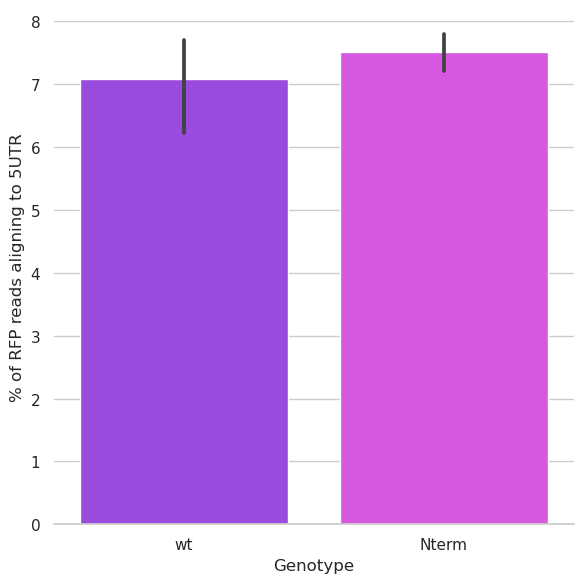

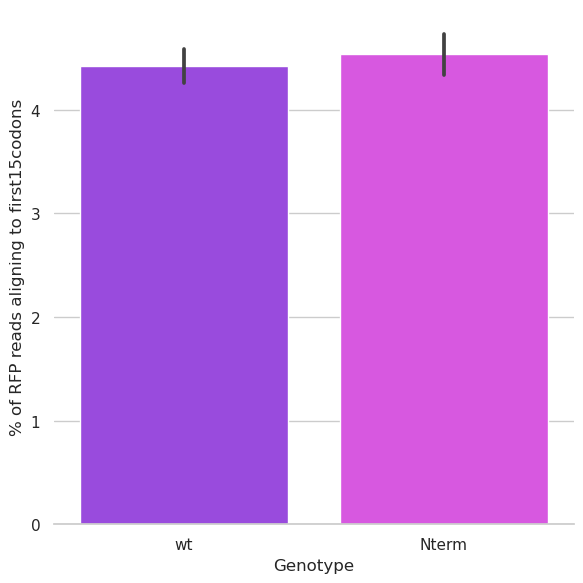

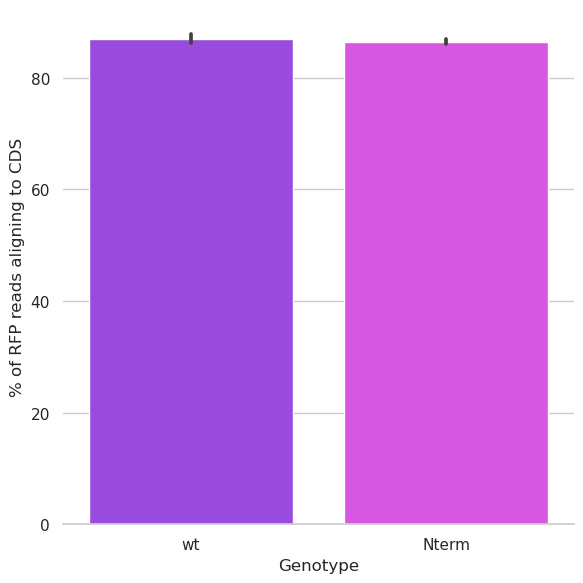

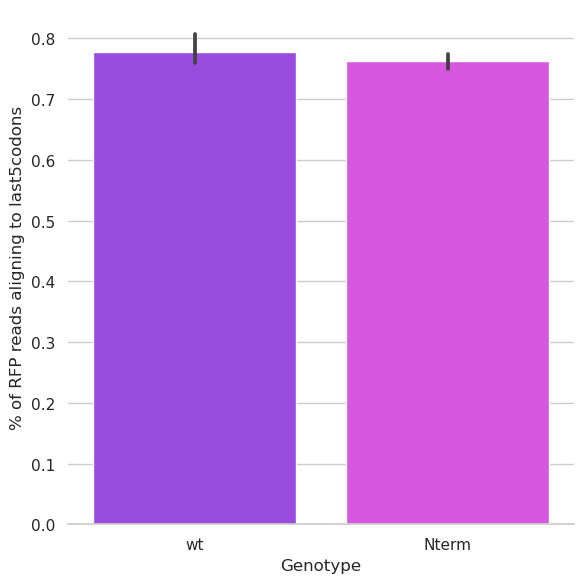

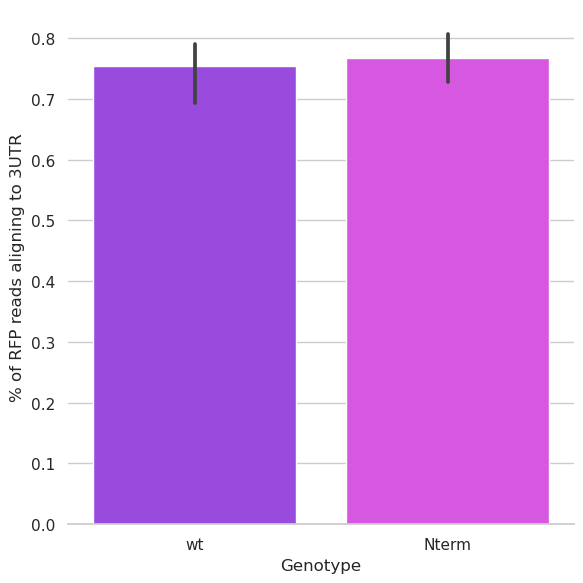

In [22]:
# iterate over each transcript region, and plot separate graphs for RPF and RNA reads that align to that region
# save each graph to PDF
sns.set(style="whitegrid")
genotype_palette3 = ['#9B33F5', '#EA41F7']

for curr_tx_region in pc_reads_per_tx_region.tx_region.unique():
    for curr_rpf_or_rna in pc_reads_per_tx_region.RPF_or_RNA.unique():
        filter_for_plot = (pc_reads_per_tx_region.tx_region==curr_tx_region) & (pc_reads_per_tx_region.RPF_or_RNA==curr_rpf_or_rna)
        g = sns.catplot(x="genotype", 
                        y="pc", 
                        data=pc_reads_per_tx_region[filter_for_plot],
                        height=6, 
                        kind="bar", 
                        palette=sns.color_palette(genotype_palette3))
        g.despine(left=True)
        g.set_ylabels(f"% of {curr_rpf_or_rna} reads aligning to {curr_tx_region}")
        g.set_xlabels('Genotype')
        g.savefig(f'percent_{curr_rpf_or_rna}_reads_aligning_to_{curr_tx_region}.pdf')

In [23]:
# reformat raw read counts as dataframe, specify sample order, replace NAs w/ zero, and write to CSV
# will be used in subsequent R notebook for limma-voom analysis
reads_tx_v_samp = pd.DataFrame({samp:sample_dfs[samp].reads_per_tx for samp in sample_dfs})
reads_tx_v_samp = reads_tx_v_samp[samp_order]
reads_tx_v_samp.fillna(0, inplace=True)
reads_tx_v_samp.to_csv('/home/tsusanto/git/ribosome_profiling/hiND14/reads_tx_vs_samp.txt', sep='\t')

In [24]:
# similarly, reformat reads per million values as dataframe, specify order, replace NAs w/ zero, and write to CSV
# this is for plotting histogram of reads per transcript in each sample, and for PCA 
rpm_tx_v_samp = pd.DataFrame({samp:sample_dfs[samp].rpm_per_tx for samp in sample_dfs})
rpm_tx_v_samp = rpm_tx_v_samp[samp_order]
rpm_tx_v_samp.fillna(value=0, inplace=True)
rpm_tx_v_samp.to_csv('/home/tsusanto/git/ribosome_profiling/hiND14/rpm_tx_vs_samp.txt', sep='\t')

In [25]:
# also export just the read counts within CDS (not including first 15 or last 5 codons)
reads_cds_v_samp = pd.DataFrame({samp:sample_dfs[samp].CDS for samp in sample_dfs})
reads_cds_v_samp = reads_cds_v_samp[samp_order]
reads_cds_v_samp.fillna(0, inplace=True)
reads_cds_v_samp.to_csv('/home/tsusanto/git/ribosome_profiling/hiND14/reads_cds_v_samp.txt', sep='\t')